<a href="https://colab.research.google.com/github/OCR-tech/AdaptDL/blob/main/examples/vision/ipynb/oxford_pets_image_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image segmentation with a U-Net-like architecture

**Author:** [fchollet](https://twitter.com/fchollet)<br>
**Date created:** 2019/03/20<br>
**Last modified:** 2020/04/20<br>
**Description:** Image segmentation model trained from scratch on the Oxford Pets dataset.

## Download the data

In [28]:
# !!wget https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
# !!wget https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
# !
!curl -O https://thor.robots.ox.ac.uk/datasets/pets/images.tar.gz
!curl -O https://thor.robots.ox.ac.uk/datasets/pets/annotations.tar.gz
# !
# !tar -xf images.tar.gz
# !tar -xf annotations.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   187  100   187    0     0    403      0 --:--:-- --:--:-- --:--:--   403
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   187  100   187    0     0    405      0 --:--:-- --:--:-- --:--:--   404


In [13]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [14]:
import tensorflow as tf
print(tf.__version__)
print("gpu:", len(tf.config.experimental.list_physical_devices("GPU")))

2.18.0
gpu: 0


## Prepare paths of input images and target segmentation masks

In [26]:
!ls

annotations.tar.gz  images.tar.gz  sample_data


In [ ]:
!tar -xzvf "/content/drive/MyDrive/Colab_Notebooks/Colab2/images.tar.gz" -C "/content/drive/MyDrive/Colab_Notebooks/Colab2/images/"

In [ ]:
!tar -xzvf "/content/drive/MyDrive/Colab_Notebooks/Colab2/annotations.tar.gz" -C "/content/drive/MyDrive/Colab_Notebooks/Colab2/annotations/"

Streaming output truncated to the last 5000 lines.
annotations/xmls/British_Shorthair_141.xml
annotations/xmls/British_Shorthair_144.xml
annotations/xmls/British_Shorthair_145.xml
annotations/xmls/British_Shorthair_148.xml
annotations/xmls/British_Shorthair_149.xml
annotations/xmls/British_Shorthair_15.xml
annotations/xmls/British_Shorthair_151.xml
annotations/xmls/British_Shorthair_153.xml
annotations/xmls/British_Shorthair_154.xml
annotations/xmls/British_Shorthair_155.xml
annotations/xmls/British_Shorthair_156.xml
annotations/xmls/British_Shorthair_157.xml
annotations/xmls/British_Shorthair_158.xml
annotations/xmls/British_Shorthair_159.xml
annotations/xmls/British_Shorthair_16.xml
annotations/xmls/British_Shorthair_160.xml
annotations/xmls/British_Shorthair_161.xml
annotations/xmls/British_Shorthair_162.xml
annotations/xmls/British_Shorthair_163.xml
annotations/xmls/British_Shorthair_164.xml
annotations/xmls/British_Shorthair_165.xml
annotations/xmls/British_Shorthair_166.xml
annot

In [31]:
!tar -xzvf "/content/drive/MyDrive/Colab_Notebooks/Colab2/annotations.tar.gz" -C "/content/drive/MyDrive/Colab_Notebooks/Colab2/annotations/"

Streaming output truncated to the last 5000 lines.
annotations/trimaps/._pomeranian_180.png
annotations/trimaps/pomeranian_180.png
annotations/trimaps/._pomeranian_181.png
annotations/trimaps/pomeranian_181.png
annotations/trimaps/._pomeranian_182.png
annotations/trimaps/pomeranian_182.png
annotations/trimaps/._pomeranian_183.png
annotations/trimaps/pomeranian_183.png
annotations/trimaps/._pomeranian_184.png
annotations/trimaps/pomeranian_184.png
annotations/trimaps/._pomeranian_185.png
annotations/trimaps/pomeranian_185.png
annotations/trimaps/._pomeranian_186.png
annotations/trimaps/pomeranian_186.png
annotations/trimaps/._pomeranian_187.png
annotations/trimaps/pomeranian_187.png
annotations/trimaps/._pomeranian_188.png
annotations/trimaps/pomeranian_188.png
annotations/trimaps/._pomeranian_189.png
annotations/trimaps/pomeranian_189.png
annotations/trimaps/._pomeranian_19.png
annotations/trimaps/pomeranian_19.png
annotations/trimaps/._pomeranian_190.png
annotations/trimaps/pomeranian

In [30]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [19]:
import os

input_dir = "images/"
target_dir = "txt/"
img_size = (1360, 800)
# img_size = (160, 160)
num_classes = 3
batch_size = 5

input_img_paths = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith(".jpg")
    ]
)
target_img_paths = sorted(
    [
        os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

print("Number of samples:", len(input_img_paths))

for input_path, target_path in zip(input_img_paths[:50], target_img_paths[:50]):
    print(input_path, "|", target_path)

FileNotFoundError: [Errno 2] No such file or directory: 'images/'

## What does one input image and corresponding segmentation mask look like?

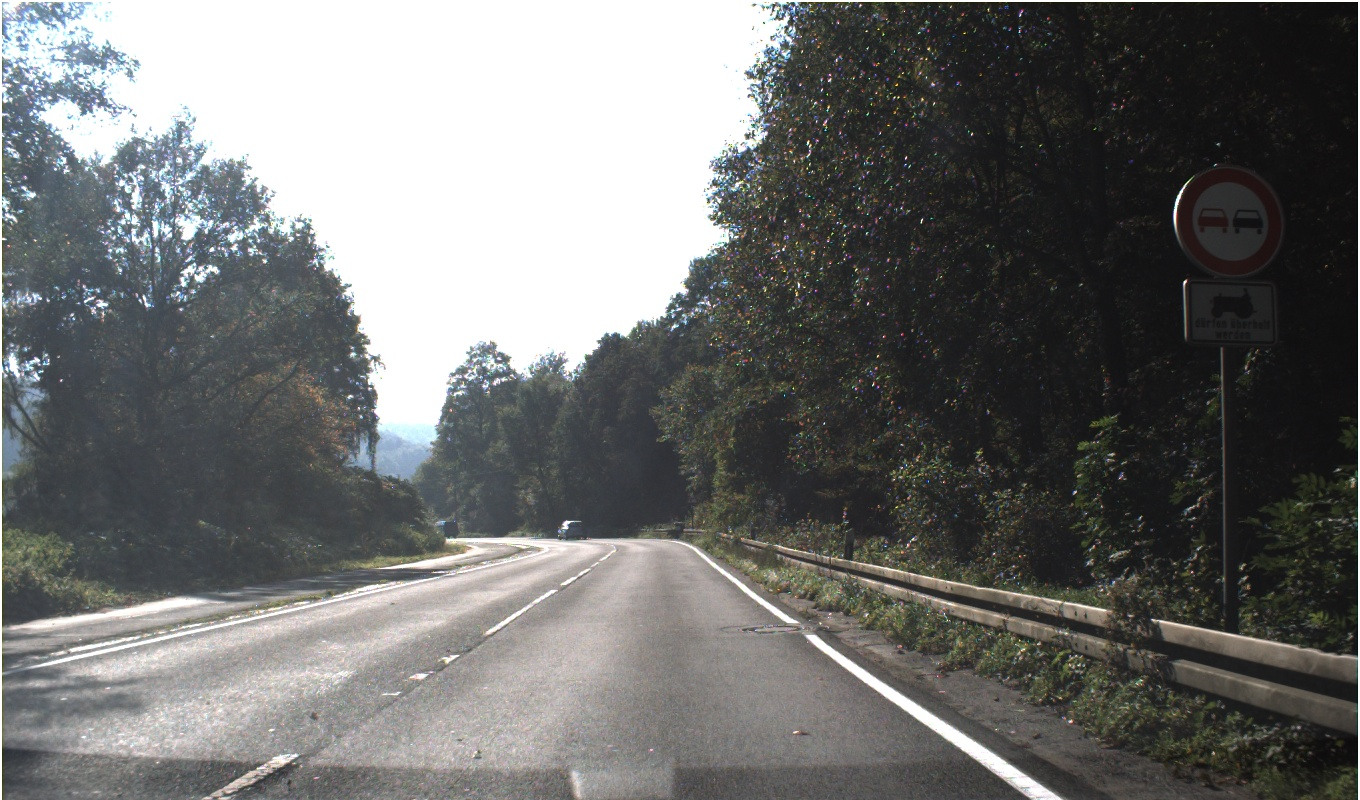

In [ ]:
from IPython.display import Image, display
from keras.utils import load_img
from PIL import ImageOps

# Display input image #7
display(Image(filename=input_img_paths[5]))

# Display auto-contrast version of corresponding target (per-pixel categories)
# img = ImageOps.autocontrast(load_img(target_img_paths[3]))
# display(img)

## Prepare dataset to load & vectorize batches of data

In [ ]:
import keras
import numpy as np
from tensorflow import data as tf_data
from tensorflow import image as tf_image
from tensorflow import io as tf_io


def get_dataset(
    batch_size,
    img_size,
    input_img_paths,
    target_img_paths,
    max_dataset_len=None,
):
    """Returns a TF Dataset."""

    def load_img_masks(input_img_path, target_img_path):
        input_img = tf_io.read_file(input_img_path)
        input_img = tf_io.decode_png(input_img, channels=3)
        input_img = tf_image.resize(input_img, img_size)
        input_img = tf_image.convert_image_dtype(input_img, "float32")

        target_img = tf_io.read_file(target_img_path)
        target_img = tf_io.decode_png(target_img, channels=1)
        target_img = tf_image.resize(target_img, img_size, method="nearest")
        target_img = tf_image.convert_image_dtype(target_img, "uint8")

        # Ground truth labels are 1, 2, 3. Subtract one to make them 0, 1, 2:
        target_img -= 1
        return input_img, target_img

    # For faster debugging, limit the size of data
    if max_dataset_len:
        input_img_paths = input_img_paths[:max_dataset_len]
        target_img_paths = target_img_paths[:max_dataset_len]
    dataset = tf_data.Dataset.from_tensor_slices((input_img_paths, target_img_paths))
    dataset = dataset.map(load_img_masks, num_parallel_calls=tf_data.AUTOTUNE)
    return dataset.batch(batch_size)


## Prepare U-Net Xception-style model

In [ ]:
from keras import layers


def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model


# Build model
model = get_model(img_size, num_classes)
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 1360, 800, 3)   │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_18 (Conv2D)        │ (None, 680, 400, 32)   │            896 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_30    │ (None, 680, 400, 32)   │            128 │ conv2d_18[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_30             │ (None, 680, 400, 32)   │              0 │ batch_normalization_3… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_31             │ (None, 680, 400, 32)   │              0 │ activation_30[0][0]    │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d_12       │ (None, 680, 400, 64)   │          2,400 │ activation_31[0][0]    │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_31    │ (None, 680, 400, 64)   │            256 │ separable_conv2d_12[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_32             │ (None, 680, 400, 64)   │              0 │ batch_normalization_3… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d_13       │ (None, 680, 400, 64)   │          4,736 │ activation_32[0][0]    │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_32    │ (None, 680, 400, 64)   │            256 │ separable_conv2d_13[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_6           │ (None, 340, 200, 64)   │              0 │ batch_normalization_3… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_19 (Conv2D)        │ (None, 340, 200, 64)   │          2,112 │ activation_30[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_14 (Add)              │ (None, 340, 200, 64)   │              0 │ max_pooling2d_6[0][0], │
│                           │                        │                │ conv2d_19[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_33             │ (None, 340, 200, 64)   │              0 │ add_14[0][0]           │
│ (Activation)         

 Total params: 2,058,979 (7.85 MB)

 Trainable params: 2,055,203 (7.84 MB)

 Non-trainable params: 3,776 (14.75 KB)

## Set aside a validation split

In [ ]:
import random

# Split our img paths into a training and a validation set
val_samples = 26
random.Random(13).shuffle(input_img_paths)
random.Random(13).shuffle(target_img_paths)

print("input_img_paths samples:", input_img_paths)
print("target_img_paths samples:", target_img_paths)

train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]
val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]

print("val_input_img_paths samples:", val_input_img_paths)
print("val_target_img_paths samples:", val_target_img_paths)

# Instantiate dataset for each split
# Limit input files in `max_dataset_len` for faster epoch training time.
# Remove the `max_dataset_len` arg when running with full dataset.

print("train_input_img_paths samples:", train_input_img_paths)
print("train_target_img_paths length:", train_target_img_paths)

print("Number of target classes:", num_classes)
print("Input image size:", img_size)
print("Batch size:", batch_size)
print("Steps per epoch:", len(train_input_img_paths) // batch_size)
print("Validation steps:", len(val_input_img_paths) // batch_size)
print

train_dataset = get_dataset(
    batch_size,
    img_size,
    train_input_img_paths,
    train_target_img_paths,
    max_dataset_len=50,
)

# valid_dataset = get_dataset(
#     batch_size, img_size, val_input_img_paths, val_target_img_paths
# )

input_img_paths samples: ['images/00031.jpg', 'images/00033.jpg', 'images/00050.jpg', 'images/00047.jpg', 'images/00035.jpg', 'images/00003.jpg', 'images/00020.jpg', 'images/00021.jpg', 'images/00017.jpg', 'images/00037.jpg', 'images/00012.jpg', 'images/00005.jpg', 'images/00010.jpg', 'images/00006.jpg', 'images/00023.jpg', 'images/00019.jpg', 'images/00022.jpg', 'images/00015.jpg', 'images/00007.jpg', 'images/00040.jpg', 'images/00024.jpg', 'images/00028.jpg', 'images/00036.jpg', 'images/00045.jpg', 'images/00030.jpg', 'images/00029.jpg', 'images/00025.jpg', 'images/00002.jpg', 'images/00038.jpg', 'images/00026.jpg', 'images/00032.jpg', 'images/00000.jpg', 'images/00039.jpg', 'images/00027.jpg', 'images/00001.jpg', 'images/00049.jpg', 'images/00013.jpg', 'images/00034.jpg', 'images/00004.jpg', 'images/00008.jpg', 'images/00046.jpg', 'images/00044.jpg', 'images/00009.jpg', 'images/00042.jpg', 'images/00014.jpg', 'images/00041.jpg', 'images/00011.jpg', 'images/00048.jpg', 'images/00043.

ValueError: Dimensions 25 and 0 are not compatible

## Train the model

In [ ]:
# Configure the model for training.
# We use the "sparse" version of categorical_crossentropy
# because our target data is integers.
model.compile(
    optimizer=keras.optimizers.Adam(1e-4), loss="sparse_categorical_crossentropy"
)

callbacks = [
    keras.callbacks.ModelCheckpoint("oxford_segmentation.keras", save_best_only=True)
]

# Train the model, doing validation at the end of each epoch.
epochs = 3
model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=valid_dataset,
    callbacks=callbacks,
    verbose=2,
)

## Visualize predictions

In [ ]:
# Generate predictions for all images in the validation set

val_dataset = get_dataset(
    batch_size, img_size, val_input_img_paths, val_target_img_paths
)
val_preds = model.predict(val_dataset)


def display_mask(i):
    """Quick utility to display a model's prediction."""
    mask = np.argmax(val_preds[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    img = ImageOps.autocontrast(keras.utils.array_to_img(mask))
    display(img)


# Display results for validation image #10
i = 10

# Display input image
display(Image(filename=val_input_img_paths[i]))

# Display ground-truth target mask
img = ImageOps.autocontrast(load_img(val_target_img_paths[i]))
display(img)

# Display mask predicted by our model
display_mask(i)  # Note that the model only sees inputs at 150x150.